# Demo: KMM enabling Intel GPU in Kubernetes

Text-to-image with Stable Diffusion running on an [Intel Flex 170](https://www.intel.com/content/www/us/en/products/sku/230019/intel-data-center-gpu-flex-170/specifications.html) GPU

## Fetch Stable Diffusion pipeline components

Pretrained pipeline from Hugging Face. Download or load from the local cache.

In [1]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base").to("cpu")

# get all components from pipeline independently to reduce memory footprint
text_encoder = pipe.text_encoder
text_encoder.eval()
unet = pipe.unet
unet.eval()
vae = pipe.vae
vae.eval()

conf = pipe.scheduler.config

del pipe

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## Convert the Text-to-Image models from PyTorch -> Onnx -> OpenVINO

In [2]:
from pathlib import Path
from implementation.conversion_helper_utils import convert_encoder, convert_unet, convert_vae_decoder, convert_vae_encoder 
from tqdm.notebook import tqdm

# Define a dir to save text-to-image models
txt2img_model_dir = Path("sd2.1")
txt2img_model_dir.mkdir(exist_ok=True)

pbar = tqdm(total=4)

# 1. Convert the Text Encoder
txt_encoder_ov_path = txt2img_model_dir / "text_encoder.xml"
convert_encoder(text_encoder, txt_encoder_ov_path)
pbar.update()

# 2. Convert the U-NET
unet_ov_path = txt2img_model_dir / "unet.xml"
convert_unet(unet, unet_ov_path, num_channels=4, width=96, height=96)
pbar.update()

# 3. Convert the VAE encoder
vae_encoder_ov_path = txt2img_model_dir / "vae_encoder.xml"
convert_vae_encoder(vae, vae_encoder_ov_path, width=768, height=768)
pbar.update()

# 4. Convert the VAE decoder
vae_decoder_ov_path = txt2img_model_dir / "vae_decoder.xml"
convert_vae_decoder(vae, vae_decoder_ov_path, width=96, height=96)
pbar.update()

pbar.close()

  0%|          | 0/4 [00:00<?, ?it/s]

## Compile models

List all kernel modules related to `i915`, Intel's GPU driver.

In [3]:
!lsmod | grep i915 || echo '<empty>'

i915                 3805184  0
intel_vsec             20480  1 i915
compat                 16384  2 intel_vsec,i915
video                  65536  1 i915
i2c_algo_bit           16384  2 ast,i915
drm_kms_helper        311296  6 compat,drm_vram_helper,ast,i915
cec                    61440  2 drm_kms_helper,i915
drm                   622592  8 drm_kms_helper,compat,drm_vram_helper,ast,drm_ttm_helper,i915,ttm


In [4]:
from IPython.display import Markdown as md
from openvino.runtime import Core

core = Core()

md(f"### Available devices: **{', '.join(core.available_devices)}**")

### Available devices: **CPU, GPU**

In [5]:
from ipywidgets import Dropdown

device = Dropdown(options=core.available_devices, description='Device:')
device

Dropdown(description='Device:', options=('CPU', 'GPU'), value='CPU')

In [7]:
pbar = tqdm(total=4)

text_enc = core.compile_model(txt_encoder_ov_path, device.value)
pbar.update()

unet_model = core.compile_model(unet_ov_path, device.value)
pbar.update()

vae_encoder = core.compile_model(vae_encoder_ov_path, device.value)
pbar.update()

vae_decoder = core.compile_model(vae_decoder_ov_path, device.value)
pbar.update()

pbar.close()

  0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
from diffusers.schedulers import LMSDiscreteScheduler
from transformers import CLIPTokenizer
from implementation.ov_stable_diffusion_pipeline import OVStableDiffusionPipeline

scheduler = LMSDiscreteScheduler.from_config(conf)
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')

ov_pipe = OVStableDiffusionPipeline(
    tokenizer=tokenizer,
    text_encoder=text_enc,
    unet=unet_model,
    vae_encoder=vae_encoder,
    vae_decoder=vae_decoder,
    scheduler=scheduler
)

# Run the inference pipeline

In [9]:
# Constant for all examples
negative_prompt = "frames, borderline, text, character, duplicate, error, out of frame, watermark, low quality, ugly, deformed, blur"
steps = 25

  0%|          | 0/25 [00:00<?, ?it/s]

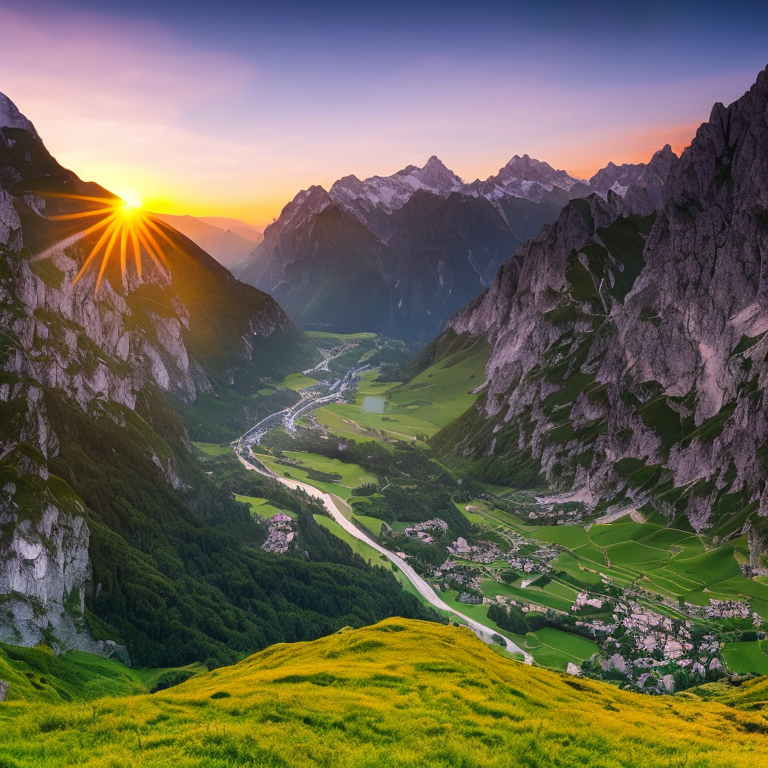

In [10]:
text_prompt = "valley in the Alps at sunset, epic vista, beautiful landscape, 4k, 8k"
seed = 42

# Run inference pipeline
result = ov_pipe(text_prompt, negative_prompt=negative_prompt, num_inference_steps=steps, seed=seed)

# Show result
result['sample'][0]

  0%|          | 0/25 [00:00<?, ?it/s]

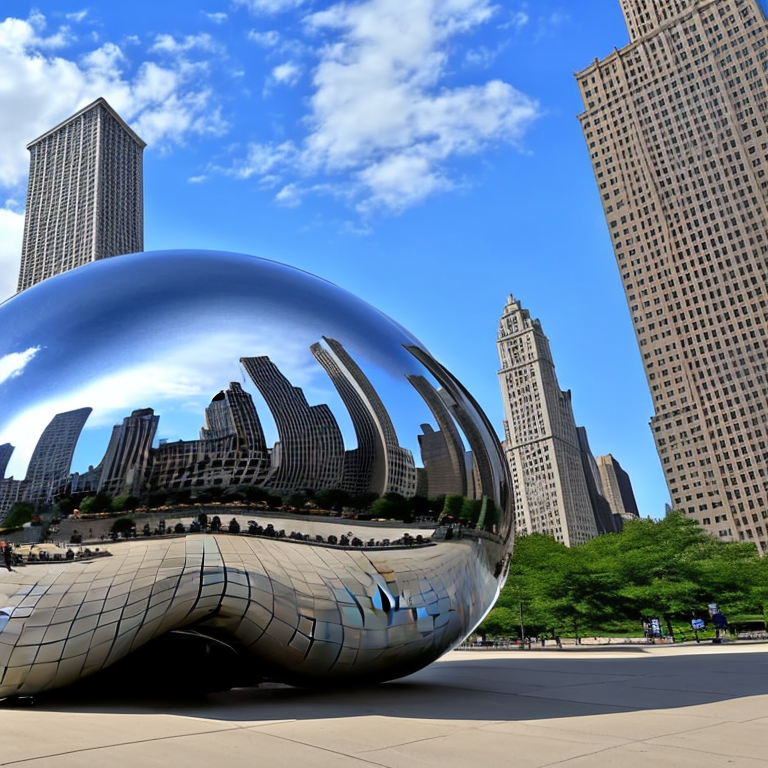

In [11]:
text_prompt = "chicago cloud gate, 4k, 8k"
seed = 123456

# Run inference pipeline
result = ov_pipe(text_prompt, negative_prompt=negative_prompt, num_inference_steps=steps, seed=seed)

# Show result
result['sample'][0]

  0%|          | 0/25 [00:00<?, ?it/s]

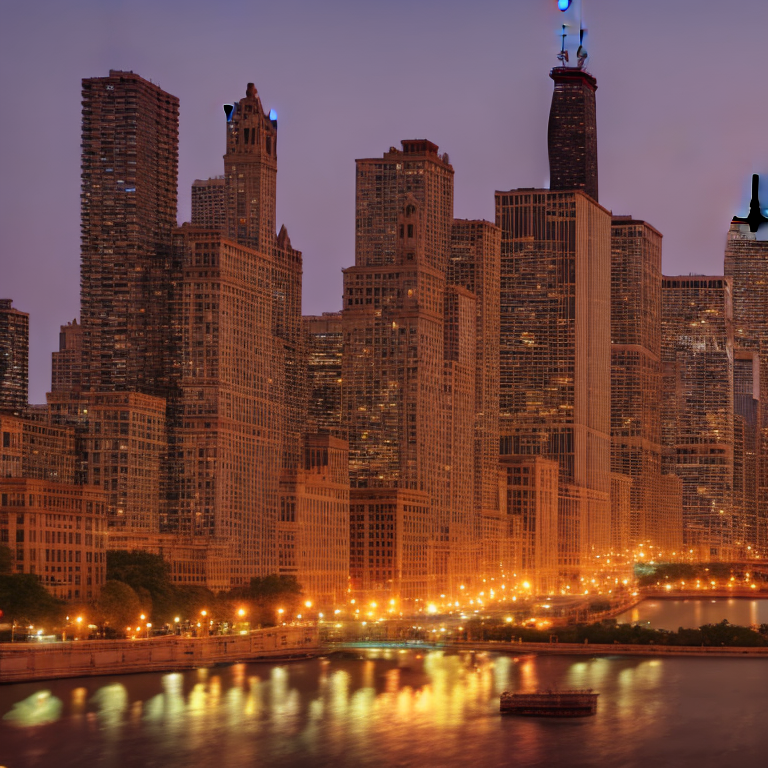

In [12]:
text_prompt = "chicago sunset, 4k, 8k"
negative_prompt = ""
seed = 2023

# Run inference pipeline
result = ov_pipe(text_prompt, negative_prompt=negative_prompt, num_inference_steps=steps, seed=seed)

# Show result
result['sample'][0]